<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/code/01ZLMA_ex06_ANCOVA_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

01ZLMA - Exercise 06

Exercise 06 of the course 01ZLMA.

# Analysis of Covariance (ANCOVA)

Assume dataset from A. J. Dobson - An Introduction to GLM, Exercise 5, that contains observations of point evaluation based on three different methods $A$, $B$, and $C$.

In [ ]:
# Standard libraries
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SciPy
from scipy.stats import f, t, ttest_ind

# Statsmodels main API
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Statsmodels statistical tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import statsmodels.stats.multicomp as mc
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import multipletests


from itertools import combinations

In [ ]:
# Load dataset from URL
url = "https://raw.githubusercontent.com/francji1/01ZLMA/main/data/data_trenink.csv"
data = pd.read_csv(url, sep=";")

# Check data summary
print(data.describe())
print(data.head())

# Convert 'group' column to categorical (factor) type
data['group'] = data['group'].astype('category')

# Check data types
print(data.dtypes)

# Boxplot with jittered points and mean points
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='y', data=data, palette="Set2")
sns.stripplot(x='group', y='y', data=data,
              color='black', alpha=0.5, jitter=True)

# Calculate and plot group means
group_means = data.groupby('group')['y'].mean().reset_index()
sns.scatterplot(x='group', y='y', data=group_means,
                marker='D', s=100, color='red', label='Mean')

# Labels and title
plt.title("Achievement score boxplot")
plt.xlabel("Method")
plt.ylabel("Achievement score")
plt.legend().remove()
plt.grid(False)
plt.tight_layout()
plt.show()

# Scatterplot of y vs. x colored and shaped by group
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='group', style='group',
                data=data, palette="Set2", s=100)

# Labels and title
plt.title("Achievement score scatterplot")
plt.xlabel("Aptitude scores")
plt.ylabel("Achievement score")
plt.grid(False)
plt.tight_layout()
plt.show()


Our goal is to determine whether the three evaluation methods (**A**, **B**, **C**) differ significantly from each other.  
First, we perform ANCOVA manually using matrix algebra based on formulas derived during the lecture. Afterwards, we verify the results using built-in functions from `statsmodels` in Python.

## ANCOVA - 01ZLMA Lecture 07

### Saturated Model

**Objective:**  
Estimate regression coefficients and calculate the deviance statistic to test model significance.

We use the notation from Lecture 07, defining two competing models:

- Full model $H_1$ (separate intercepts for each group):
$$
y_{ij} = \beta x_{ij} + u_i + e_{ij}, \quad i \in \{1,2,3\}, \quad j = 1,\ldots,7.
$$

- Reduced model $H_0$ (common intercept for all groups):
$$
y_{ij} = \beta x_{ij} + u + e_{ij}, \quad i \in \{1,2,3\}, \quad j = 1,\ldots,7.
$$

Matrix formulation of the full ANCOVA model $H_1$:

$$
y = X\beta + Z u + e
$$

The following matrices and formulas are utilized:


- Matrix for group indicators (design matrix):
$$
G = (Z^T Z)^{-1}
$$

- Projection matrix removing group means:
$$
P = I - Z G Z^T
$$

- Estimated slope coefficient:
$$
\hat{\beta} = (X^T P X)^{-1} X^T P y
$$

- Estimated group intercepts:
$$
\hat{u} = G Z^T y - G Z^T X \hat{\beta}
$$

- Deviance statistic (sum of squared residuals under the estimated full mode):
$$
D = (y - X \hat{\beta} - Z \hat{u})^T(y - X \hat{\beta} - Z \hat{u}) =  (y - \hat{y})^T (y - \hat{y})
$$


#### Testing the difference between models ($H_0$ vs. $H_1$):

The reduced model $H_0$ assumes one common intercept ($u$), thus $Z$ becomes a vector of ones ($Z_0$), and similar calculations lead to a deviance statistic $D_0$. The difference in deviance is compared using an $F$-test statistic defined by:
$$
F = \frac{(D_0 - D)/df_{numerator}}{D/df_{denominator}}
$$

with degrees of freedom:
- Numerator: $df_{numerator} = (number\ of\ groups - 1) = 2$
- Denominator: $df_{denominator} = (n - number\ of\ groups - number\ of\ regressors) = 21 - 4 = 17$

We then test this $F$ statistic against an $F$-distribution with $(2,17)$ degrees of freedom at a chosen significance level (typically $\alpha = 0.05$). A significant $F$ indicates that the group intercepts differ significantly, implying the methods differ from each other.

In [ ]:
# Manual calculation of ANCOVA in Python
# Prepare data vectors
y = data['y'].values
x = data['x'].values


# Group indicator matrix Z (one-hot encoding of group membership)
Z = np.kron(np.eye(3), np.ones((7, 1)))  # shape (21, 3)

# Matrix G = (Z^T Z)^{-1}
G = inv(Z.T @ Z)  # shape (3, 3)

# Projection matrix P = I - Z G Z^T
P = np.eye(len(y)) - Z @ G @ Z.T  # shape (21, 21)

# Helper function for safe inversion or division
def safe_inv_mult(A, B):
    if np.ndim(A) == 0 or A.shape == ():  # scalar
        return B / A
    else:  # matrix
        return inv(A) @ B

# Estimate beta (common slope) for full model
A = x.T @ P @ x
beta_hat = safe_inv_mult(A, x.T @ P @ y)
beta_hat = beta_hat.item()
print(f"beta: {beta_hat}")

# Estimate group-specific intercepts u
u_hat = G @ Z.T @ (y - x * beta_hat)
print(f"u1: {u_hat[0]}, u2: {u_hat[1]}, u3: {u_hat[2]}")

# Predicted values under full model
y_hat = beta_hat * x + Z @ u_hat

# Deviance for the full model
D = np.sum((y - y_hat)**2)
print(f"D (full model): {D}")


In [ ]:
# Reduced model (common intercept for all groups)
Z0 = np.ones((21, 1))
G0 = np.array([[1/21]])
P0 = np.eye(21) - (1/21) * np.ones((21, 21))

# Estimate beta under reduced model
A0 = x.T @ P0 @ x
beta_hat = safe_inv_mult(A0, x.T @ P0 @ y)
beta0_hat = beta_hat.item()
print(f"beta0: {beta0_hat}")

# Estimate common intercept u0
u0_hat = np.mean(y) - beta0_hat * np.mean(x)
print(f"u0: {u0_hat}")

# Predicted values under reduced model
y_hat0 = beta0_hat * x + Z0.flatten() * u0_hat

# Deviance for the reduced model
D0 = np.sum((y - y_hat0)**2)
print(f"D0 (reduced model): {D0}")

# F-test to compare models
F_stat = ((D0 - D)/(3 - 1)) / (D/(21 - 3 - 1))
p_value = 1 - f.cdf(F_stat, 2, 17)
critical_value = f.ppf(0.95, 2, 17)

print(f"F-statistic: {F_stat}")
print(f"Critical value (alpha=0.05): {critical_value}")
print(f"p-value: {p_value}")

# Decision
if F_stat > critical_value:
    print("Reject H0: Methods significantly differ.")
else:
    print("Fail to reject H0: No significant difference among methods.")


In [ ]:
# ANCOVA verification using statsmodels built-in functions

# Fit ANCOVA model with interaction (full model: different intercepts, common slope)
model_full = smf.ols('y ~ x + group', data=data).fit()
anova_full = sm.stats.anova_lm(model_full, typ=2)
print(model_full.summary())
print(anova_full)

# Fit ANCOVA model without group (reduced model: common intercept)
model_reduced = smf.ols('y ~ x', data=data).fit()
anova_reduced = sm.stats.anova_lm(model_reduced, typ=2)
print(model_reduced.summary())
print(anova_reduced)

# Compare full vs reduced models with ANOVA
anova_compare = sm.stats.anova_lm(model_reduced, model_full)
print(anova_compare)

# Extracting F-statistic and p-value directly
F_builtin = anova_compare['F'][1]
p_builtin = anova_compare['Pr(>F)'][1]

print(f"Built-in F-statistic: {F_builtin}")
print(f"Built-in p-value: {p_builtin}")

if p_builtin < 0.05:
    print("Reject H0: Methods significantly differ (built-in statsmodels).")
else:
    print("Fail to reject H0: No significant difference among methods (built-in statsmodels).")


In [ ]:
# GLM (Gaussian family) - Full model (group-specific intercepts, common slope)
glm_full = smf.glm('y ~ x + group', data=data, family=sm.families.Gaussian()).fit()
#print("GLM Full Model Summary:")
#print(glm_full.summary())
print("\nGLM:")
print(f"GLM Full Model Deviance: {glm_full.deviance}")

# GLM Reduced model (common intercept and slope, no group effects)
glm_reduced = smf.glm('y ~ x', data=data, family=sm.families.Gaussian()).fit()
#print("\nGLM Reduced Model Summary:")
#print(glm_reduced.summary())
print(f"GLM Reduced Model Deviance: {glm_reduced.deviance}")

# GLM: Deviance difference and F-test
dev_diff_glm = glm_reduced.deviance - glm_full.deviance
df_diff = glm_reduced.df_resid - glm_full.df_resid

# Calculate F-statistic
F_glm = (dev_diff_glm / df_diff) / (glm_full.deviance / glm_full.df_resid)

# Calculate p-value correctly using scipy.stats
p_val_glm = 1 - f.cdf(F_glm, df_diff, glm_full.df_resid)
print(f"GLM Deviance Difference: {dev_diff_glm}")
print(f"GLM F-statistic: {F_glm}")
print(f"GLM p-value: {p_val_glm}")

# OLS approach for comparison
ols_full = smf.ols('y ~ x + group', data=data).fit()
ols_reduced = smf.ols('y ~ x', data=data).fit()

# Residual Sum of Squares (RSS) comparison (Equivalent to Deviance for Gaussian models)
rss_full = sum(ols_full.resid**2)
rss_reduced = sum(ols_reduced.resid**2)

dev_diff_ols = rss_reduced - rss_full
df_diff_ols = ols_reduced.df_resid - ols_full.df_resid
F_ols = (dev_diff_ols / df_diff_ols) / (rss_full / ols_full.df_resid)
p_val_ols = 1 - f.cdf(F_ols, df_diff_ols, ols_full.df_resid)


print("\nOLS:")
print(f"OLS RSS Full Model: {rss_full}")
print(f"OLS RSS Reduced Model: {rss_reduced}")
print(f"OLS RSS Difference: {dev_diff_ols}")
print(f"OLS F-statistic: {F_ols}")
print(f"OLS p-value: {p_val_ols}")

# Compare results
comparison = pd.DataFrame({
    "Model": ["GLM", "OLS"],
    "Deviance/RSS Difference": [dev_diff_glm, dev_diff_ols],
    "F-statistic": [F_glm, F_ols],
    "p-value": [p_val_glm, p_val_ols]
})

print("\nComparison of GLM and OLS Results:")
print(comparison)


## Significance Test of the Explanatory Variable \( x \) (Slope)

We test the hypothesis:
$$
H_0: \beta = 0
$$

This means we compare the full ANCOVA model, including the explanatory variable \( x \), against a reduced model without the slope (only group intercepts):

- **Full model** \( H_1 \):
$$
y_{ij} = \beta x_{ij} + u_i + e_{ij},\quad i \in \{1,2,3\}, j=1,\dots,7.
$$

- **Reduced model** (no slope) \( H_{x0} \):
$$
y_{ij} = u_i + e_{ij},\quad i \in \{1,2,3\}, j=1,\dots,7.
$$

We will perform the test manually (using deviance/RSS comparison) and confirm our results using built-in `statsmodels` functions in Python.


In [ ]:
# Reduced model without slope (group intercepts only)
model_no_slope = smf.ols('y ~ group - 1', data=data).fit()
print(model_no_slope.summary())

# Deviance (RSS) of reduced model (no slope)
Dx = sum(model_no_slope.resid**2)
print(f"Reduced model deviance (Dx): {Dx}")

# Deviance of full model (from previous step)
model_full = smf.ols('y ~ x + group', data=data).fit()
D_full = sum(model_full.resid**2)
print(f"Full model deviance (D): {D_full}")

# Calculate F-statistic manually
df_diff = 1  # Difference in parameters (only beta)
df_resid_full = model_full.df_resid
F_stat = ((Dx - D_full)/df_diff) / (D_full / df_resid_full)
p_val = 1 - f.cdf(F_stat, df_diff, df_resid_full)
crit_val = f.ppf(0.95, df_diff, df_resid_full)

print("\nManual test results:")
print(f"F-statistic: {F_stat}")
print(f"Critical value (alpha=0.05): {crit_val}")
print(f"p-value: {p_val}")

# Decision based on manual calculation
if p_val < 0.05:
    print("Reject H0: The explanatory variable x is significant.")
else:
    print("Fail to reject H0: The explanatory variable x is not significant.")

# Verify with built-in ANOVA function
anova_results = sm.stats.anova_lm(model_no_slope, model_full)
print("\nANOVA results using statsmodels:")
print(anova_results)


In [ ]:
# GLM comparison (Gaussian family)

# Reduced model without slope
glm_no_slope = smf.glm('y ~ group - 1', data=data, family=sm.families.Gaussian()).fit()
Dx_glm = glm_no_slope.deviance

# Full model (group intercepts + slope)
glm_full = smf.glm('y ~ x + group', data=data, family=sm.families.Gaussian()).fit()
D_full_glm = glm_full.deviance

# GLM deviance difference
dev_diff_glm = Dx_glm - D_full_glm
df_diff_glm = glm_no_slope.df_resid - glm_full.df_resid
F_glm = (dev_diff_glm/df_diff_glm) / (D_full_glm/glm_full.df_resid)
p_val_glm = 1 - f.cdf(F_glm, df_diff_glm, glm_full.df_resid)

print("\nGLM  results:")
print(f"GLM F-statistic: {F_glm}")
print(f"GLM p-value: {p_val_glm}")

# Decision based on GLM
if p_val_glm < 0.05:
    print("GLM confirms: Reject H0, explanatory variable x is significant.")
else:
    print("GLM confirms: Fail to reject H0, explanatory variable x is not significant.")


### Multiple comparisons (Bonferroni)
Returning to the general model, and since the hypothesis of equality of the effects of each method has been rejected, let us perform multiple comparisons to see which pairs are significantly different.

Fixed effects values for the different methods and a table of their differences:

In [ ]:
# Retrieve estimates from the full ANCOVA model
model_full = smf.ols('y ~ x + group', data=data).fit()

# Extract intercepts (group means differences) and slope from model_full
params = model_full.params
beta_hat = params['x']
u_hat = {
    'A': params['Intercept'],
    'B': params['Intercept'] + params['group[T.B]'],
    'C': params['Intercept'] + params['group[T.C]']
}

n_group = data['group'].value_counts()

# Mean absolute differences between groups
meanabs = pd.DataFrame({
    'mean.g.B': [abs(u_hat['A'] - u_hat['B']), 0],
    'mean.g.C': [abs(u_hat['A'] - u_hat['C']), abs(u_hat['B'] - u_hat['C'])]
}, index=['mean.g.A', 'mean.g.B'])

print("Mean absolute differences:")
print(meanabs)

# Residual variance estimate (sigma squared)
sigma_hat = model_full.mse_resid
df_resid = model_full.df_resid
print(f"\nResidual variance (sigma^2): {sigma_hat}")

# Bonferroni critical t-value
alpha = 0.05
k_comparisons = 3  # A vs B, A vs C, B vs C
t_val = t.ppf(1 - alpha/(2*k_comparisons), df_resid)
print(f"Bonferroni critical t-value: {t_val}")

# Mean of x per group

x_means = data.groupby('group', observed=True)['x'].transform('mean')

# Compute Exx correctly (x - group means of x)
Exx = np.sum((data['x'] - x_means)**2)
print(f"Exx: {Exx}")

# Bonferroni critical values calculations (corrected)
def BF_calc(group1, group2):
    n1, n2 = n_group[group1], n_group[group2]
    xm1, xm2 = data.loc[data['group'] == group1, 'x'].mean(), data.loc[data['group'] == group2, 'x'].mean()
    term = (1/n1 + 1/n2 + ((xm1 - xm2)**2) / Exx)
    return np.sqrt(sigma_hat) * t_val * np.sqrt(term)

# Recalculate BF values with corrected code
BF_12 = BF_calc('A', 'B')
BF_13 = BF_calc('A', 'C')
BF_23 = BF_calc('B', 'C')

# Bonferroni critical differences table (corrected)
BF = pd.DataFrame({
    'mean.g.B': [BF_12, 0],
    'mean.g.C': [BF_13, BF_23]
}, index=['mean.g.A', 'mean.g.B'])

print("\nCorrected Bonferroni critical differences:")
print(BF)

# Check significant differences again
SIGNIF = meanabs > BF
print("\nCorrected Significant differences (True = significant):")
print(SIGNIF)


# Built-in Bonferroni-adjusted pairwise comparisons
comp = MultiComparison(data['y'] - beta_hat * data['x'], data['group'])
bonf_result = comp.allpairtest(sm.stats.ttest_ind, method='bonf')[0]
print("\nBuilt-in Bonferroni-adjusted pairwise comparisons:")
print(bonf_result)


In [ ]:
# Plotting data and fitted regression lines per group
colors = {'A': 'red', 'B': 'blue', 'C': 'black'}
markers = {'A': 's', 'B': '^', 'C': 'o'}

plt.figure(figsize=(8, 6))
for grp in data['group'].cat.categories:
    grp_data = data[data['group'] == grp]
    plt.scatter(grp_data['x'], grp_data['y'],
                color=colors[grp], marker=markers[grp], label=f'Method {grp}')

# Add fitted lines per group
x_vals = np.array([data['x'].min(), data['x'].max()])
for grp in data['group'].cat.categories:
    plt.plot(x_vals, u_hat[grp] + beta_hat * x_vals,
             color=colors[grp])

plt.xlabel('Before training')
plt.ylabel('After training')
plt.legend(title="Method")
plt.title("ANCOVA: Data with fitted regression lines")
plt.grid(True)
plt.show()


## ANOVA – analysis of variance without covariate (variable $x$)

We perform a standard ANOVA to evaluate the significance of differences between the groups without considering the covariate \( x \). We will then perform multiple comparisons, including Tukey HSD and Bonferroni tests, and calculate confidence intervals.


In [ ]:
# Verify that 'group' is categorical
data['group'] = data['group'].astype('category')
print(f"'group' is categorical: {data['group'].dtype.name == 'category'}")

# ANOVA without covariate x
anova_model = smf.ols('y ~ group', data=data).fit()
anova_table = sm.stats.anova_lm(anova_model)
print("\nANOVA table (without covariate x):")
print(anova_table)

# Diagnostic plots for ANOVA
fig = plt.figure(figsize=(12,8))
sm.graphics.plot_regress_exog(anova_model, 'group[T.B]', fig=fig)
plt.tight_layout()
plt.show()

# Conclusion based on ANOVA table:
# Significant p-value (<0.05) indicates differences between groups.


In [ ]:
group_means = data.groupby('group', observed=True)['y'].mean()
print("\nGroup means:")
print(group_means)


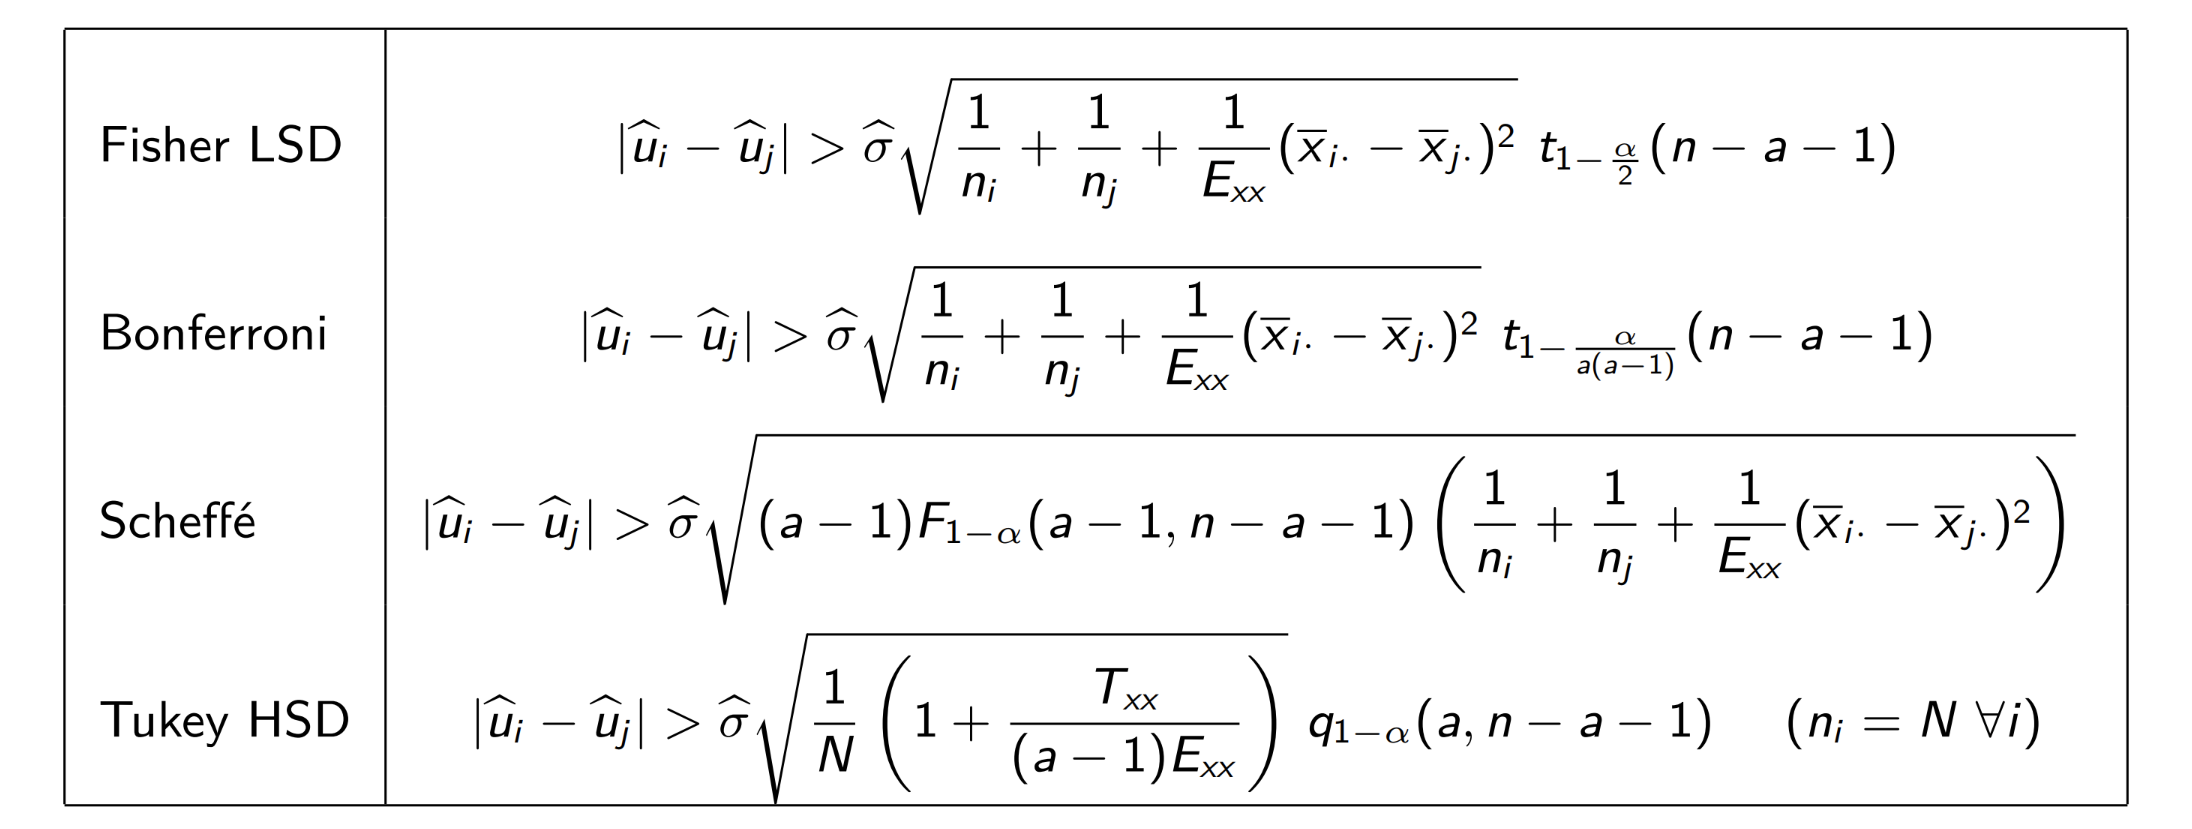

In [ ]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='y', data=data, order=group_means.sort_values(ascending=False).index)
plt.title('Boxplot grouped by method (ordered by mean)')
plt.show()

In [ ]:
# Tukey HSD test
tukey_result = pairwise_tukeyhsd(endog=data['y'], groups=data['group'], alpha=0.05)
print("\nTukey HSD results:")
print(tukey_result)

# Plotting Tukey HSD results
tukey_result.plot_simultaneous(comparison_name='A')
plt.title('Tukey HSD confidence intervals')
plt.show()


In [ ]:
# Extract results into DataFrame
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
tukey_df['group_pair'] = tukey_df['group1'] + ' - ' + tukey_df['group2']
tukey_df['diff'] = tukey_df['meandiff'].astype(float)
tukey_df['lower'] = tukey_df['lower'].astype(float)
tukey_df['upper'] = tukey_df['upper'].astype(float)

# Prepare plot
fig, ax = plt.subplots(figsize=(8, 4))

# Y positions
y_pos = np.arange(len(tukey_df))

# Plot difference points
ax.errorbar(tukey_df['diff'], y_pos,
            xerr=[tukey_df['diff'] - tukey_df['lower'], tukey_df['upper'] - tukey_df['diff']],
            fmt='o', color='black', ecolor='gray', capsize=5)

# Reference line at zero (no difference)
ax.axvline(x=0, color='red', linestyle='--')

# Set y-ticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(tukey_df['group_pair'])

ax.set_xlabel('Difference between group means')
ax.set_title('Tukey HSD: Differences and 95% CIs')

plt.tight_layout()
plt.show()


In [ ]:
# Get unique group labels
groups = data['group'].unique()

# Prepare all pairwise combinations
pairwise_combinations = list(combinations(groups, 2))
print(pairwise_combinations)

# Conduct pairwise t-tests manually
results = []
for grp1, grp2 in pairwise_combinations:
    y1 = data[data['group'] == grp1]['y']
    y2 = data[data['group'] == grp2]['y']
    t_stat, p_val = ttest_ind(y1, y2, equal_var=True)
    results.append({'Group1': grp1, 'Group2': grp2, 't-stat': t_stat, 'p-value': p_val})

pairwise_results_df = pd.DataFrame(results)

# Perform Bonferroni correction
corrected = multipletests(pairwise_results_df['p-value'], alpha=0.05, method='bonferroni')

pairwise_results_df['p-value corrected'] = corrected[1]
pairwise_results_df['reject H0'] = corrected[0]

# Print results clearly
print("Pairwise t-tests with Bonferroni correction:")
print(pairwise_results_df[['Group1', 'Group2', 't-stat', 'p-value', 'p-value corrected', 'reject H0']])


* R's pairwise.t.test performs pairwise tests using pooled variance from ANOVA (based on residual degrees of freedom and pooled error term from ANOVA).

* Python’s previous manual scipy.stats.ttest_ind performs independent t-tests for each pair separately, each with its own variance estimate, not necessarily pooled from the entire dataset.

* R uses ANOVA residual Mean Square Error (MSE) and degrees of freedom (from the full ANOVA model) for all comparisons.

* Python previously used individual pairwise variances, thus differing in standard errors, resulting in different t-values and p-values.

In [ ]:
# ANOVA model to obtain pooled MSE and df
anova_model = smf.ols('y ~ group', data=data).fit()
MSE = anova_model.mse_resid
df_resid = anova_model.df_resid

groups = data['group'].cat.categories
pairwise_results = []

# Perform pairwise tests using pooled variance (MSE)
for grp1, grp2 in combinations(groups, 2):
    mean1 = data[data['group'] == grp1]['y'].mean()
    mean2 = data[data['group'] == grp2]['y'].mean()
    n1 = data[data['group'] == grp1].shape[0]
    n2 = data[data['group'] == grp2].shape[0]

    se = np.sqrt(MSE * (1/n1 + 1/n2))
    t_stat = (mean1 - mean2) / se
    p_val = 2 * (1 - t.cdf(np.abs(t_stat), df_resid))
    pairwise_results.append({'Group1': grp1, 'Group2': grp2, 't-stat': t_stat, 'p-value': p_val})

pairwise_df = pd.DataFrame(pairwise_results)

# Apply Bonferroni correction
pairwise_df['p-value Bonferroni'] = multipletests(pairwise_df['p-value'], method='bonferroni')[1]

print("Pairwise t-tests using ANOVA pooled variance (matching R):")
print(pairwise_df)
